# DISTRIBUITED ALGORITHMS - K-MEANS||

Project for the Physics of Data course Management and Analysis of Physics Dataset mod.B, academic year 2024-2025.

In [20]:
#Libraries used
import warnings
import dask
import dask.array as da
from dask.distributed import Client
from dask_ml.preprocessing import StandardScaler
from dask_ml.cluster import KMeans as DaskKMeans
import numpy as np
import math
import time
import pandas as pd
from dask_ml.metrics import pairwise_distances
from dask_ml.metrics import pairwise_distances_argmin_min
from time import time
from timeit import default_timer as timer
from dask_ml.datasets import make_blobs
import pandas as pd
from dask.distributed import SSHCluster
import matplotlib.pyplot as plt
import pickle
import numba
from dask.distributed import SSHCluster, Client
from dask_ml.decomposition import PCA
from matplotlib import colormaps
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans as SklearnKMeans
from dask_ml.preprocessing import StandardScaler
from sklearn.datasets import make_blobs as skl_make_blobs
from kmeans_parallel_dask import kmeans_parallel #our library for implementing kmeans|| in Dask

In [21]:
# Configurazione Dask
dask.config.set({
    'distributed.comm.timeouts.connect': '60s',
    'distributed.comm.timeouts.tcp': '60s',
    'distributed.deploy.lost-worker-timeout': '30s',
})

def setup_cluster():
    """Setup del cluster SSH con tutte e 4 le VM"""
    VM_IPS = ['10.67.22.253','10.67.22.253', '10.67.22.93', '10.67.22.68', '10.67.22.80']
    
    print(f"Setting up SSH cluster with {len(VM_IPS) -1 } VMs...")
    
    cluster = SSHCluster(
        hosts=VM_IPS,
        connect_options={
            "username": "ubuntu",
            "client_keys": ["/home/ubuntu/MAPDB-13.pem"],
            "known_hosts": None,
            "connect_timeout": 30,
        },
        scheduler_options={
            "port": 8786,
            "dashboard_address": ":8787",
        },
        worker_options={
            "n_workers":1,
            "nthreads": 4,
            "memory_limit": "7.8GB",
        },
    )
    
    client = Client(cluster)
    print("Waiting for workers...")
    client.wait_for_workers(n_workers=4, timeout=30)
    
    print(f"✅ Cluster ready with {len(client.scheduler_info()['workers'])} workers")
    print(f"Dashboard: {client.dashboard_link}")
    
    return client, cluster

client, cluster=setup_cluster()

Setting up SSH cluster with 4 VMs...


2025-09-15 15:16:39,963 - distributed.deploy.ssh - INFO - 2025-09-15 15:16:39,962 - distributed.scheduler - INFO - State start
2025-09-15 15:16:39,966 - distributed.deploy.ssh - INFO - 2025-09-15 15:16:39,963 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-69iq4mp4', purging
2025-09-15 15:16:39,969 - distributed.deploy.ssh - INFO - 2025-09-15 15:16:39,966 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.253:8786
2025-09-15 15:16:40,673 - distributed.deploy.ssh - INFO - 2025-09-15 15:16:40,672 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.253:41869'
2025-09-15 15:16:40,752 - distributed.deploy.ssh - INFO - 2025-09-15 15:16:40,752 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.68:45677'
2025-09-15 15:16:40,758 - distributed.deploy.ssh - INFO - 2025-09-15 15:16:40,757 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.80:38291'
2025-09-15 15:16:40,838 - d

Waiting for workers...
✅ Cluster ready with 4 workers
Dashboard: http://10.67.22.253:8787/status


In [22]:
# Connect the Dask client to the existing cluster using the scheduler's address
#client = Client("tcp://localhost:8786")
client = Client(cluster)

# Print the cluster configuration
scheduler_info = client.scheduler_info()
workers_info = scheduler_info['workers'] 
# Get the information for the first worker in the cluster
worker = list(workers_info.values())[0]
n_workers = len(workers_info)
n_threads = worker['nthreads']

print(f'client dashboard link: {client.dashboard_link}')
print(f"Cluster setup with {n_workers} workers, each with {n_threads} threads")
client

client dashboard link: http://10.67.22.253:8787/status
Cluster setup with 4 workers, each with 4 threads


<Client: 'tcp://10.67.22.253:8786' processes=4 threads=16, memory=29.06 GiB>

## K-means||

The K-Means method is widely used for unsupervised clustering tasks. One common technique for weight initialization in K-Means is known as K-Means++, though it is primarily a sequential algorithm. A scalable version, referred to as K-Means∥, is introduced and described in detail in the paper available at https://arxiv.org/pdf/1203.6402.

Parallel K-Means enhances the K-Means++ algorithm by distributing computations across multiple processors, which speeds up the clustering of large datasets. This approach allows for efficient scaling and faster convergence. The proposed method focuses on improving the initialization procedure and then employs Lloyd's scalable algorithm.
Below, we explain the algorithm for the initialization phase of Parallel K-Means (which uses K-Means++) and Lloyd's algorithm.

### The k-means|| Algorithm

The **k-means||** method is a scalable variant of k-means++ designed for distributed environments.  
Its goal is to speed up the initialization step, which has a large impact on the quality and efficiency of the final clustering.

**Inputs**:
- $X$: a dataset of $n$ points in $d$ dimensions (here represented as a Dask array).
- $k$: desired number of clusters.
- $\ell$: oversampling factor, typically chosen on the order of $k$.
- $t$: number of rounds (commonly proportional to $\log \psi$, where $\psi$ is the clustering cost).

**Output**:
- $C$: a set of $k$ final cluster centroids.

---

#### Steps

1. **Initial centroid**  
   - Choose one data point at random from $X$ as the first centroid $c_1$.  
   - Initialize the set $C = \{c_1\}$.

2. **Compute the initial cost**  
   - Evaluate $\psi = \sum_{x \in X} d(x, C)^2$, i.e. the sum of squared distances from each point to its nearest centroid in $C$.

3. **Sampling phase** (repeat for $O(\log \psi)$ iterations):  
   - For each $x \in X$, assign a probability  
     $p(x) = \frac{\ell \cdot d(x, C)^2}{\sum_{x' \in X} d(x', C)^2}$.  
   - Sample points independently according to $p(x)$ and add them to $C$.  
   - After these rounds, the candidate set $C$ typically contains $O(\ell \cdot \log \psi)$ points.

4. **Reclustering**  
   - Each candidate $x \in C$ is given a weight $w_x$, equal to the number of original points that are closer to $x$ than to any other candidate.  
   - The weighted set $C$ is reclustered into exactly $k$ centroids using Lloyd’s iterations, seeded with a **weighted k-means++** initialization.

---

### Weighted k-means++ (used in step 4)

1. Pick the first centroid $c_1$ uniformly at random.  
2. For each point $x$, compute its squared distance $D(x)^2$ to the closest chosen centroid.  
3. Select the next centroid at random, with probability proportional to $D(x)^2$.  
   Points farther from the existing centroids are more likely to be chosen.  
4. Repeat until $k$ centroids are chosen, updating distances each time.  
5. Proceed with standard Lloyd’s algorithm.

---

### Scalable Lloyd’s Iterations

Once initialized, the algorithm iterates between:  

1. **Assignment**: each point $x_i$ is assigned to the closest centroid  
   $c(i) = \arg \min_{j \in \{1,\dots,k\}} \|x_i - \mu_j\|^2$.  

2. **Update**: centroids are recomputed as the (possibly weighted) mean of the points in their cluster  
   $\mu_j = \frac{1}{|C_j|}\sum_{x_i \in C_j} x_i$.  

This process continues until convergence or a maximum iteration count.  

---

### Notes on our Implementation vs Dask-ML 
- We rely on Dask’s `pairwise_distances` for distance computation, as it is substantially faster than NumPy’s `linalg.norm` in this context.  
- Centroids are stored as NumPy arrays for convenience, though this requires collecting them to memory at each iteration. This is memory-costly but simpler to manage.


## Test custom implementation on syntetic datasets

### Test 1: speed test

In this section we benchmark the execution time of three different KMeans implementations on synthetic datasets of increasing size and dimensionality (5,000 features):  

- **Custom KMeans||**: our self-implemented parallel initialization and Lloyd iterations,  
- **Dask-ML KMeans**: the distributed implementation with k-means|| initialization,  
- **Scikit-learn KMeans**: the standard sequential implementation with k-means++ initialization.  

For each dataset size, the benchmark was repeated multiple times to compute mean and standard deviation of execution times. The results (see figure below) show that, within the range of dataset sizes that a single machine can still handle, the sequential scikit-learn implementation is consistently faster than the parallel/distributed versions. This highlights the trade-off between parallelism overhead and raw speed: while distributed approaches are essential for scaling to much larger datasets, they introduce coordination costs that make them slower on small to medium workloads.  

In [23]:
import time

warnings.filterwarnings("ignore", category=UserWarning)

try:
    # probe support once
    _probe = SklearnKMeans(n_clusters=2, n_init=1, random_state=0)
    _probe.fit(np.array([[0.,0.],[1.,1.]]), sample_weight=np.array([1.,1.]))

    KMeans = SklearnKMeans
except TypeError:
    class _KMeansCompat(SklearnKMeans):
        def fit(self, X, y=None, sample_weight=None):
            # ignore sample_weight if the version doesn't support it
            return super().fit(X, y)
    KMeans = _KMeansCompat 

# -----------------------------
# Data generator (NumPy -> Dask)
# -----------------------------
def generate_data(N, k, dim, seed, target_mb):
    """
    Return Dask array X (N, dim) and NumPy y, with row-wise chunking targeting ~target_mb per chunk.
    """
    B = 8  # float64 bytes
    rows_per_chunk = max(1, math.floor((target_mb * 1024 * 1024) / (dim * B)))
    chunks = (rows_per_chunk, dim)

    X_np, y_np = skl_make_blobs(n_samples=N, centers=k, n_features=dim, random_state=seed)
    X = da.from_array(X_np, chunks=chunks)
    return X, y_np, chunks

# -----------------------------
# Benchmark
# -----------------------------
def benchmark_kmeans(N_values, R=3, k=4, n_feat=5000, target_mb=50, seed=42):
    """
    For each N in N_values, run R repetitions of:
      - custom kmeans_parallel (Dask)
      - Dask-ML KMeans
      - sklearn KMeans (on NumPy)
    Returns a pandas DataFrame with per-run times and also plots mean±std.
    """
    rows = []
    for N in N_values:
        print(f"\n=== N={N} ===")
        for r in range(R):
            # ---- data (Dask) ----
            X, y, chunks = generate_data(N=N, k=k, dim=n_feat, seed=seed + r, target_mb=target_mb)

            # ---- scale (Dask -> stays Dask) ----
            scaler = StandardScaler(with_mean=True, with_std=True)
            X_norm = scaler.fit_transform(X)           # Dask array
            X_norm = X_norm.persist()                  # materialize in cluster memory

            # ---- custom (Dask) ----
            t0 = time.time()
            _ = kmeans_parallel(X=X_norm, k=k, l=2)   
            rows.append({"N": N, "method": "CustomKMeans", "time": time.time() - t0, "rep": r})

            # ---- Dask-ML (Dask) ----
            t0 = time.time()
            dask_km = DaskKMeans(n_clusters=k, init="k-means||",
                                 init_max_iter=100, oversampling_factor=2,
                                 random_state=seed + r)
            _ = dask_km.fit(X_norm)
            rows.append({"N": N, "method": "DaskMLKMeans", "time": time.time() - t0, "rep": r})

            # ---- sklearn (NumPy) ----
            X_np = X_norm.compute()                    # move to driver for sklearn
            t0 = time.time()
            sk_km = SklearnKMeans(n_clusters=k, init="k-means++", random_state=seed + r)
            _ = sk_km.fit(X_np)
            rows.append({"N": N, "method": "SklearnKMeans", "time": time.time() - t0, "rep": r})
            del X_np  # free memory

    df = pd.DataFrame(rows)

    # ---- plot mean ± std ----
    fig, ax = plt.subplots(figsize=(10, 6))
    for method in ["CustomKMeans", "DaskMLKMeans", "SklearnKMeans"]:
        sub = df[df.method == method].groupby("N")["time"]
        means, stds = sub.mean(), sub.std()
        ax.errorbar(means.index, means.values, yerr=stds.values, marker="o",
                    capsize=4, label=method)

    ax.set_xlabel("Number of samples (N)")
    ax.set_ylabel("Execution time (s)")
    ax.set_title(f"KMeans benchmark (features={n_feat}, R={R}, target≈{target_mb}MB/chunk)")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

    return df



=== N=10 ===

=== N=1120 ===

=== N=2230 ===

=== N=3340 ===

=== N=4450 ===

=== N=5560 ===

=== N=6670 ===

=== N=7780 ===

=== N=8890 ===

=== N=10000 ===


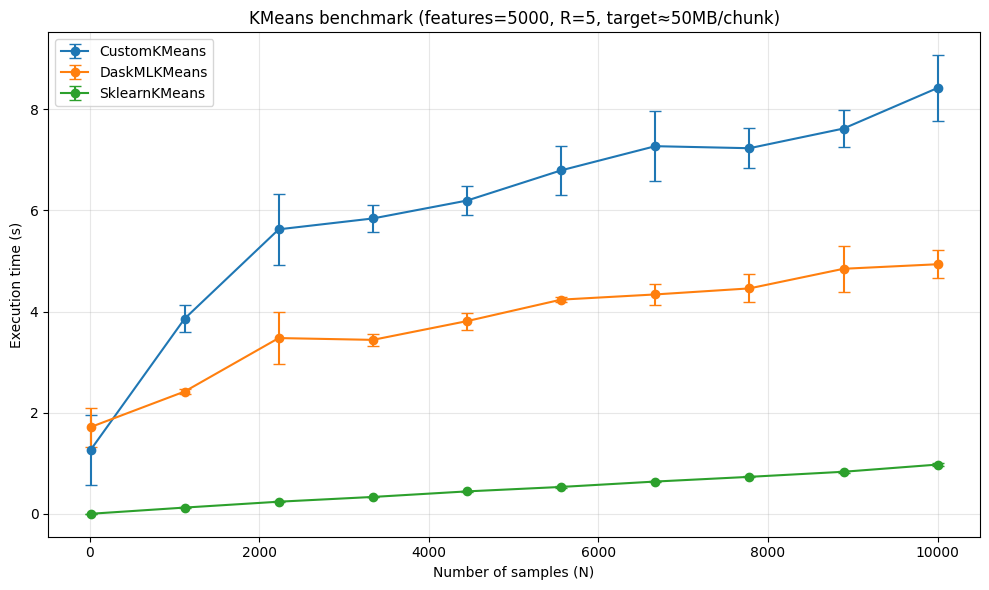

In [24]:
# Run test benchmark on small sizes
import warnings
warnings.filterwarnings("ignore", category=UserWarning) # We want to ignore the warning relative to the slowdown caused by
#materializing all the data in one machine when executing the sequential algorithm
benchmark_results = benchmark_kmeans(N_values=np.linspace(10, 10000, 10, dtype=int), R=5)

### Test 2: handling a syntetic, large dataset

In [6]:
# ==============================
# Generation of synthetic dataset
# ==============================

N=100000 #number of points
k=4 # number of centers
n_feat= 5000 #number of features
seed=42

Target= 200 # target (MB) per chunck
B=8 #bytes per element
rows_per_chunk = int((Target * 1024 * 1024) / (n_feat * B))
chunks = (rows_per_chunk,n_feat)  # row-wise chucnking, do not divide the features

def generate_data(N=N, k=k, dim=n_feat, random_state=seed,chunks=chunks):
    X, y = make_blobs(n_samples=N, centers=k, n_features=dim, random_state=random_state, chunks=chunks) #synthetic data, true label
    return X, y

In [7]:
#Generate synthetic dataset
data, labels=generate_data()

In [8]:
#Inspect the data
data.persist()

dask.array<concatenate, shape=(100000, 5000), dtype=float64, chunksize=(5242, 5000), chunktype=numpy.ndarray>

In [9]:
# Normalize the data before clustering

# X_sparse: dask.array of sparse blocks (e.g. scipy.sparse.csr in each chunk, or sparse.COO)

scaler = StandardScaler(with_mean=True, with_std=True)
data_normalized = scaler.fit_transform(data)
del data

"""
mean = data.mean(axis=0, split_every=8)
std  = data.std(axis=0,  ddof=1, split_every=8)
data_normalized = ((data - mean) / std)
del data
"""

"""
scaler = StandardScaler(with_mean=True) # for scaling with a sparse matrix
%time data_normalized = scaler.fit_transform(data)
del data
"""

'\nscaler = StandardScaler(with_mean=True) # for scaling with a sparse matrix\n%time data_normalized = scaler.fit_transform(data)\ndel data\n'

In [10]:
data_normalized=data_normalized.persist() #Make data persistent to speed up future computation
data_normalized

dask.array<truediv, shape=(100000, 5000), dtype=float64, chunksize=(5242, 5000), chunktype=numpy.ndarray>

In [11]:
from dask.distributed import performance_report


#Our implementation
with performance_report(filename="kmean_our.html"):  
    %time synt_labels, synt_centroids = kmeans_parallel(X=data_normalized, k=k, l=2)

CPU times: user 1.25 s, sys: 63.5 ms, total: 1.32 s
Wall time: 27 s


In [12]:
#Dask's implementation
%time dask_ml_kmeans = DaskKMeans(n_clusters=k,init="k-means||", init_max_iter=100, oversampling_factor=2, random_state=42).fit(data_normalized)    
data_dask_centers = dask_ml_kmeans.cluster_centers_
data_dask_labels = dask_ml_kmeans.labels_

CPU times: user 1.3 s, sys: 57.2 ms, total: 1.36 s
Wall time: 10.9 s


In [13]:
#Plot

from IPython.display import IFrame
# Display the HTML report in Jupyter
IFrame(src="kmean_our.html", width=1280, height=720)

In [14]:
def plot_clusters_by_row(X_pca, cluster_labels, centroids, pca, true_labels=None, title_prefix='Cluster'):
    """
    Plot one row per cluster:
    - left: predicted cluster points + centroid
    - right: same points colored the same, showing their true label

    Parameters
    ----------
    X_pca : np.ndarray, shape (n_samples, 2)
        PCA-projected data to plot.
    cluster_labels : np.ndarray, shape (n_samples,)
        Predicted labels (e.g., from KMeans).
    centroids : np.ndarray, shape (n_clusters, n_features)
        Centroids to project and plot.
    pca : PCA object
        Fitted PCA used to project centroids.
    true_labels : np.ndarray, shape (n_samples,), optional
        True labels to show in the right panel (colors will match predicted).
    title_prefix : str
        Prefix for plot titles (e.g. 'KMeans', 'Custom', etc.).
    """

    # Project centroids into PCA space
    centroids_pca = pca.transform(np.asarray(centroids))

    # Sort centroids and relabel cluster IDs
    sorted_idx = np.lexsort(centroids_pca.T)
    centroids_pca_sorted = centroids_pca[sorted_idx]
    remap = {old: new for new, old in enumerate(sorted_idx)}
    cluster_labels_sorted = np.vectorize(remap.get)(cluster_labels)

    # Prepare consistent colors
    K = len(centroids_pca_sorted)
    cmap = plt.cm.get_cmap("tab10", K)

    for i in range(K):
        fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

        idx = np.where(cluster_labels_sorted == i)[0]
        X_cluster = X_pca[idx]
        color = cmap(i)

        # Left: Predicted cluster i
        ax[0].scatter(X_cluster[:, 0], X_cluster[:, 1], color=color, s=5, label=f'Cluster {i}')
        ax[0].scatter(centroids_pca_sorted[i, 0], centroids_pca_sorted[i, 1],
                      marker='x', s=100, color='black', label='Centroid')
        ax[0].set_title(f'{title_prefix} - cluster {i+1}')
        ax[0].legend()

        # Right: Same points, but optionally show their true label (in same color)
        if true_labels is not None:
            ax[1].scatter(X_cluster[:, 0], X_cluster[:, 1], color=color, s=5)
            ax[1].set_title(f'True labels - cluster {i+1} ')
        else:
            ax[1].scatter(X_cluster[:, 0], X_cluster[:, 1], color=color, s=5)
            ax[1].set_title('True labels not available')

        for a in ax:
            a.set_xlabel("PC1")
            a.set_ylabel("PC2")
            a.grid(True, alpha=0.3)

        plt.suptitle(f'{title_prefix} {i} — PCA projection')
        plt.tight_layout()
        plt.show()

In [15]:
def plot_all_clusters(
    X_pca,
    label_sets,
    titles,
    centroid_sets=None,
    pca=None,
    colormap="tab10"
):
    """
    Plot multiple clusterings in a row with consistent coloring and optional centroids.

    Parameters
    ----------
    X_pca : np.ndarray
        2D PCA projection of the dataset (n_samples, 2)
    label_sets : list of np.ndarray
        List of label arrays (e.g., [synt_labels, dask_labels, true_labels])
    titles : list of str
        Titles for each subplot
    centroid_sets : list of arrays or None
        List of centroid arrays (same length as label_sets), or None
    pca : fitted PCA object or None
        Used to project centroids (if provided)
    colormap : str
        Name of a Matplotlib colormap (e.g., "tab10", "Set3", "Paired")
    """
    n_plots = len(label_sets)
    fig, axs = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5), sharex=True, sharey=True)

    if centroid_sets is None:
        centroid_sets = [None] * n_plots

    for i, (labels, title, centroids) in enumerate(zip(label_sets, titles, centroid_sets)):
        ax = axs[i]
        unique_labels = np.unique(labels)
        K = len(unique_labels)

        # Slice the colormap to K colors
        base_cmap = colormaps.get_cmap(colormap)
        colors = base_cmap(np.linspace(0, 1, K))
        cmap = ListedColormap(colors)

        for j, lbl in enumerate(unique_labels):
            idx = labels == lbl
            ax.scatter(X_pca[idx, 0], X_pca[idx, 1], color=cmap(j), s=5, label=f"Cluster {lbl+1}")

        # project and plot centroids if provided
        if centroids is not None and pca is not None:
            centroids_pca = pca.transform(np.asarray(centroids))
            ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
                       marker='x', s=100, color='black', label='Centroids')

        ax.set_title(title)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.grid(True, alpha=0.3)
        ax.legend(markerscale=2, fontsize=7)

    plt.tight_layout()
    plt.show()

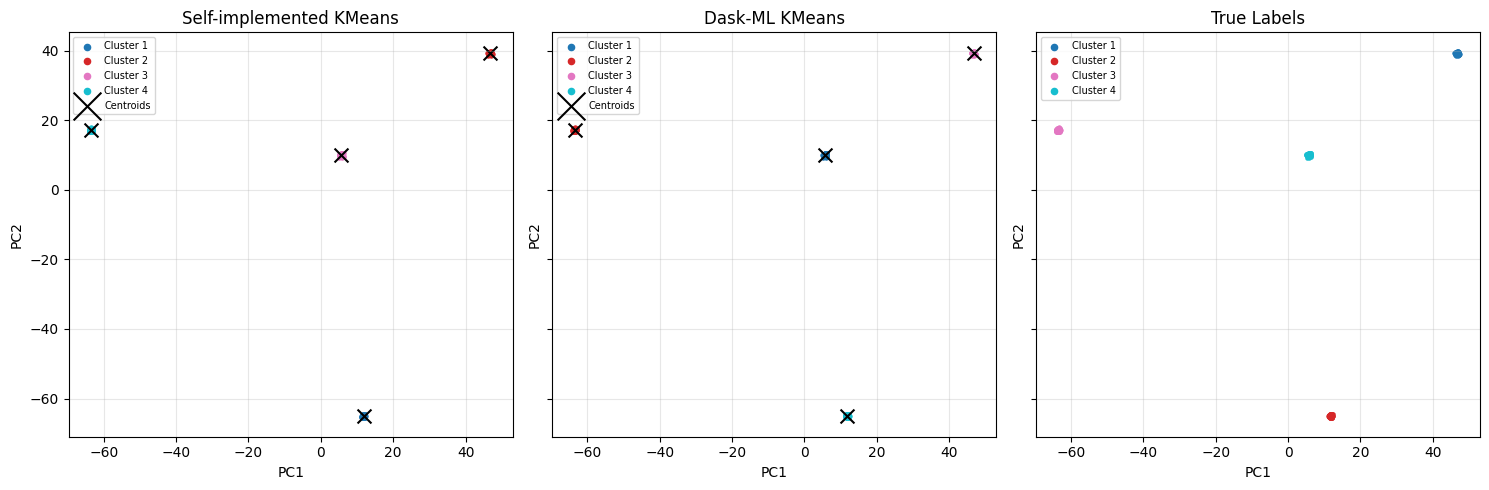

In [16]:
import numpy as np
from sklearn.decomposition import PCA
import dask.array as da

# Parameters
subset = int(data_normalized.shape[0] / 100)
N_FIT = 10000
rng = np.random.default_rng(0)

# Step 1: Sample & fit PCA
n_total = int(data_normalized.shape[0])
idx_np = rng.choice(n_total, size=N_FIT, replace=False)
X_sample = da.take(data_normalized, idx_np, axis=0).compute()

pca = PCA(n_components=2, random_state=0)
pca.fit(X_sample)

# Step 2: Transform subset
X_subset = data_normalized[:subset].compute()
X_pca = pca.transform(X_subset)

# Step 3: Extract labels and centroids
try:
    synt_labels_sub = synt_labels[:subset].compute()
    synt_centroids_np = np.asarray(getattr(synt_centroids, "compute", lambda: synt_centroids)())
    labels_sub = labels[:subset].compute()
except Exception as e:
    raise RuntimeError(f"Data loading failed: {e}")

# Compute labels for the first `subset` samples using the Dask-ML KMeans centers
# Subset of labels from Dask-ML KMeans
data_dask_labels_sub = data_dask_labels[:subset].compute()


plot_all_clusters(
    X_pca=X_pca,
    label_sets=[synt_labels_sub, data_dask_labels_sub, labels_sub],
    titles=["Self-implemented KMeans", "Dask-ML KMeans", "True Labels"],
    centroid_sets=[synt_centroids, data_dask_centers, None],
    pca=pca,
    colormap="tab10"
)

/tmp/ipykernel_281775/2711090679.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", K)


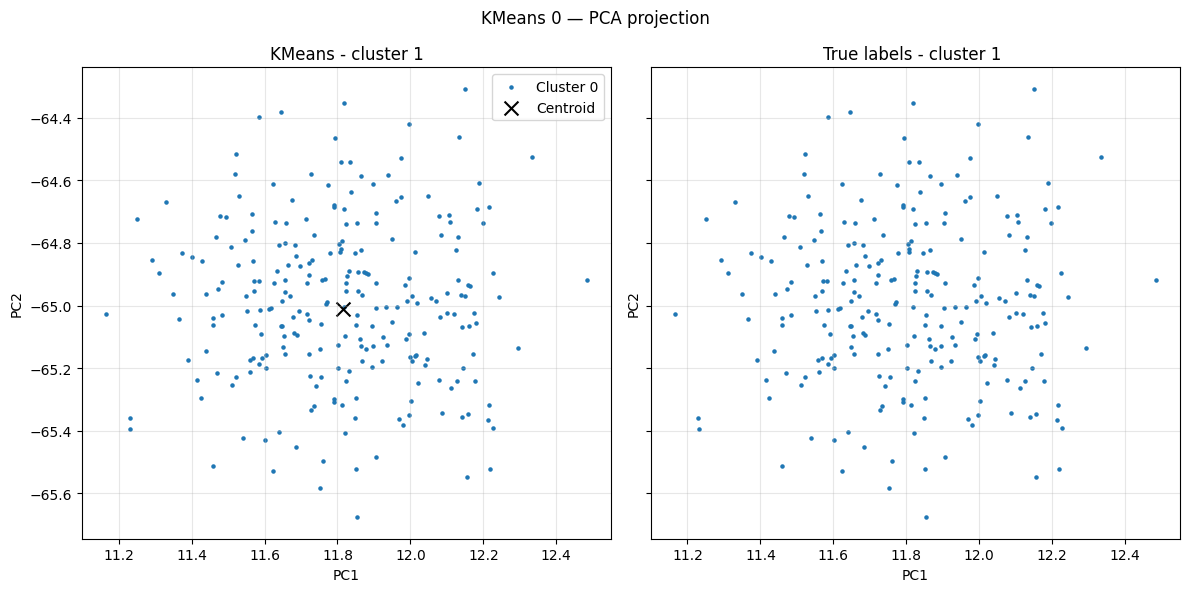

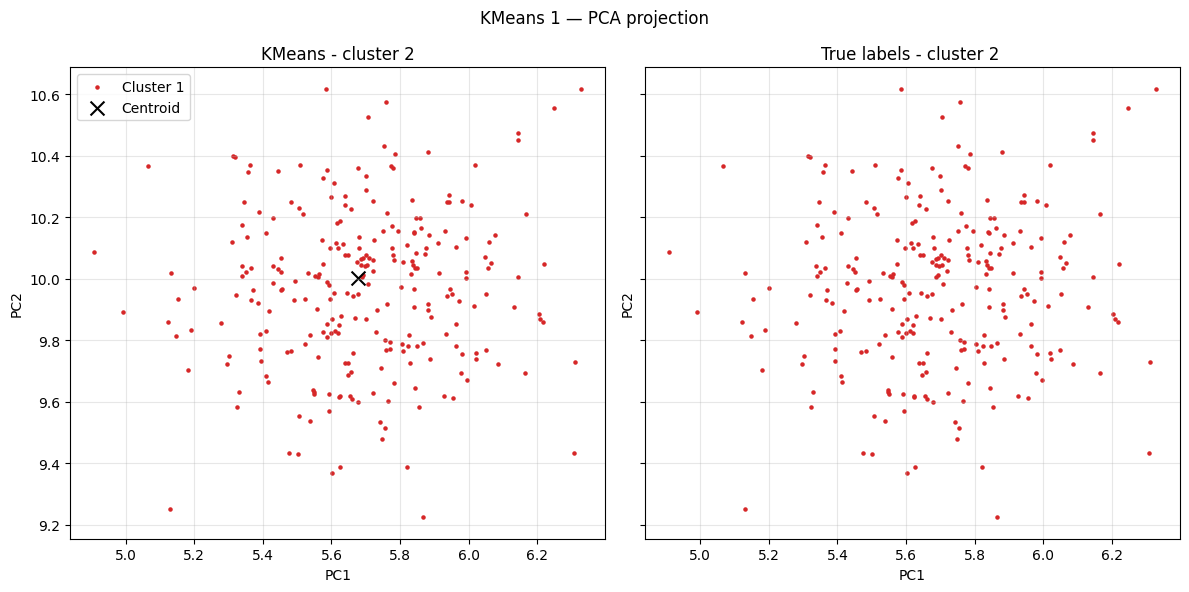

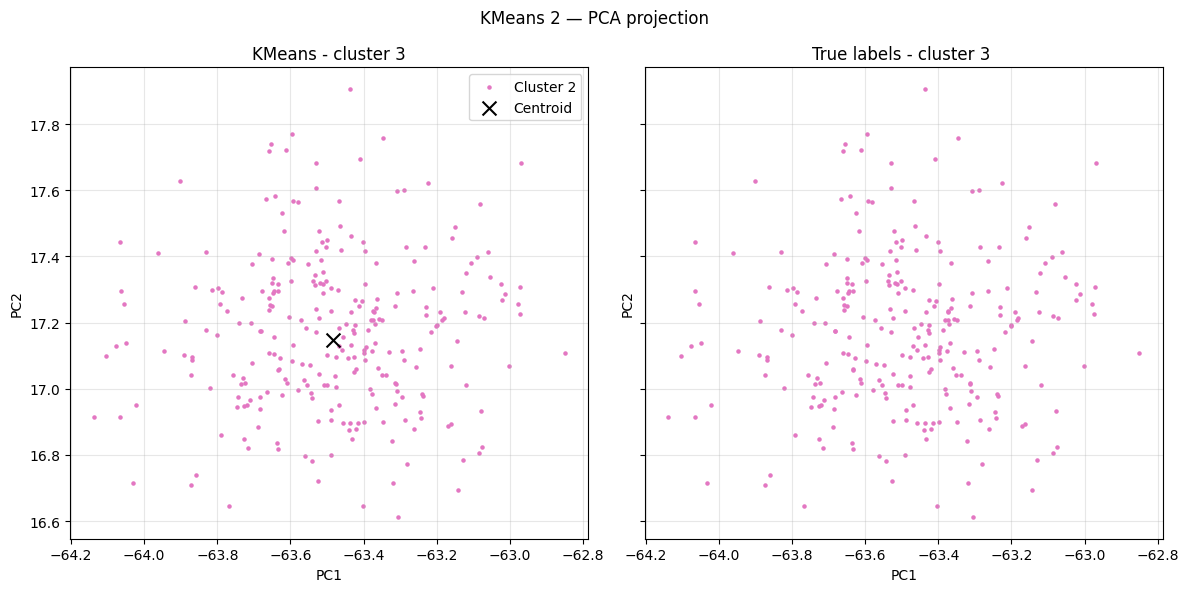

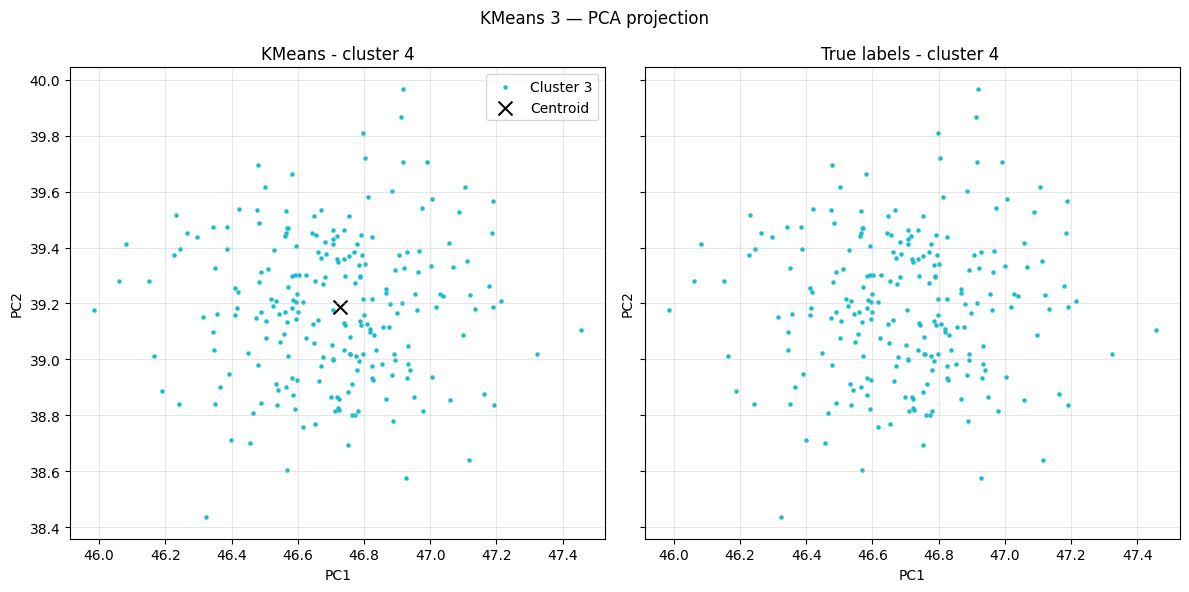

In [17]:
# Step 4: Plot with the reusable function

#Plot Self implemented Kmeans vs True label for each cluster
plot_clusters_by_row(
    X_pca=X_pca,
    cluster_labels=synt_labels_sub,
    centroids=synt_centroids_np,
    pca=pca,
    true_labels=labels_sub,
    title_prefix="KMeans"
)

/tmp/ipykernel_281775/2711090679.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", K)


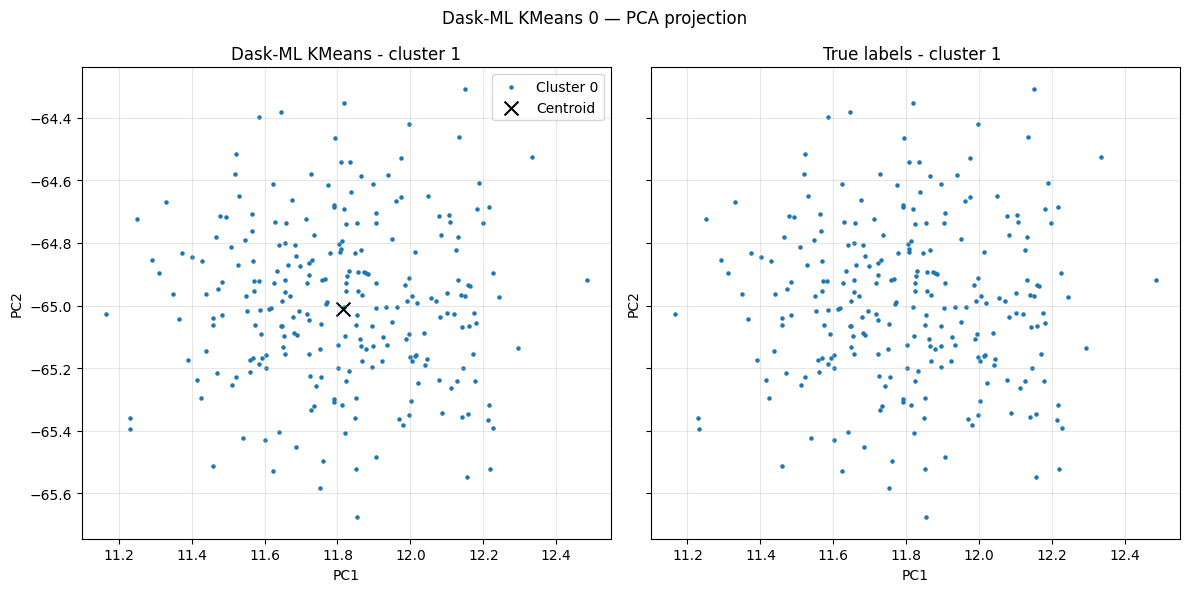

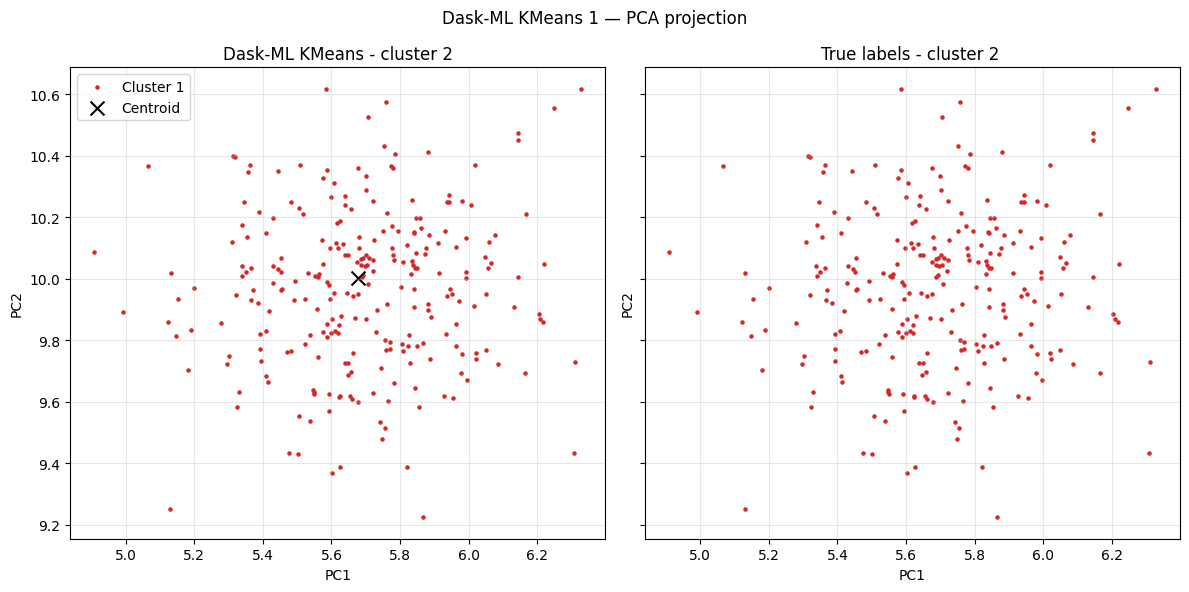

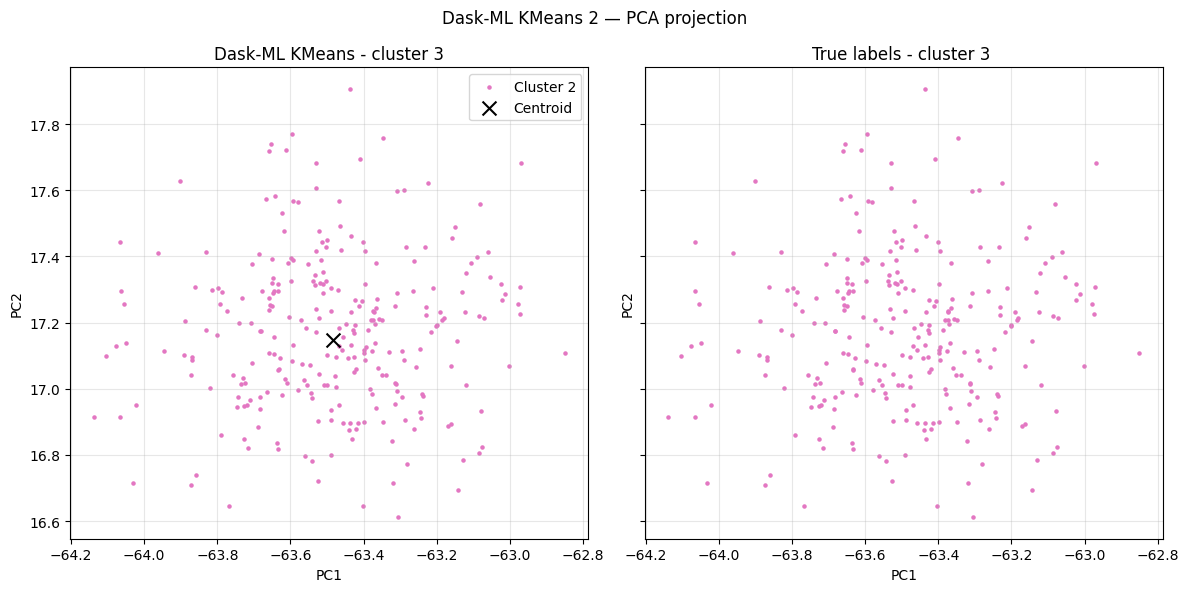

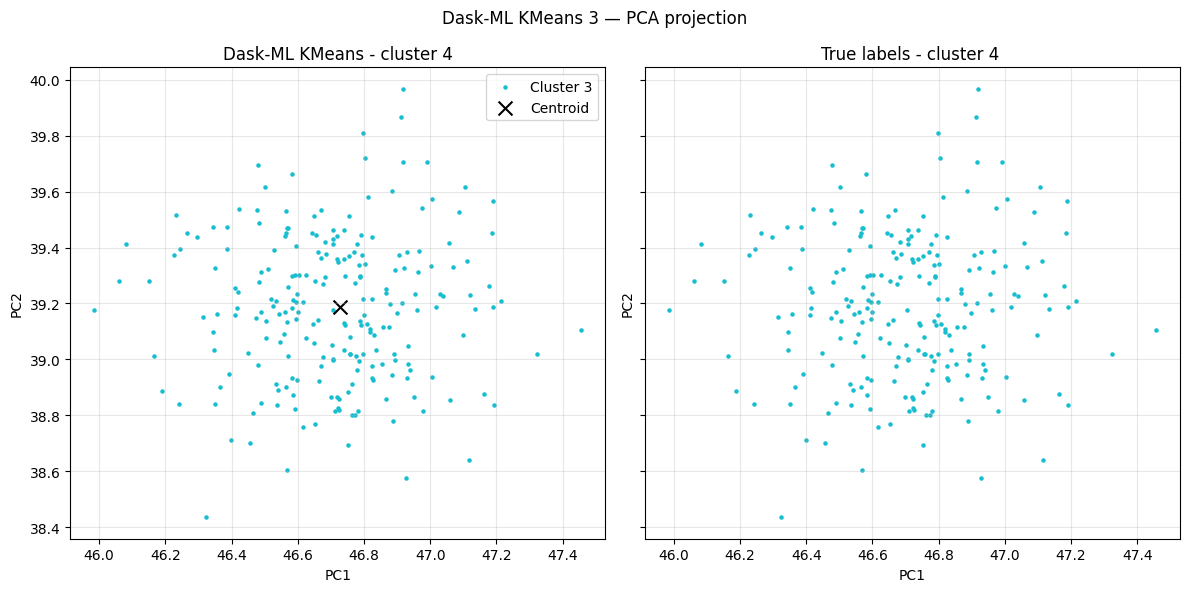

In [18]:
# Test for dask library kmeans|| clustering vs true label for each cluster
try:
    data_dask_labels_sub = data_dask_labels[:subset].compute()
    data_dask_centroids_np = np.asarray(getattr(data_dask_centers, "compute", lambda: data_dask_centers)())
    labels_sub = labels[:subset].compute()
except Exception as e:
    raise RuntimeError(f"Data loading failed: {e}")

plot_clusters_by_row(
    X_pca=X_pca,
    cluster_labels=data_dask_labels_sub,
    centroids=data_dask_centroids_np,
    pca=pca,
    true_labels=labels_sub,
    title_prefix="Dask-ML KMeans"
)

In [19]:
#Testing equality of the centroids
# Define a function to sort centroids for consistency
def sort_centroids(centroids):
    # Use np.lexsort to sort the centroids by all dimensions
    sorted_indices = np.lexsort(centroids.T)
    return centroids[sorted_indices]

# Sort both sets of centroids
sorted_dask_centers = sort_centroids(data_dask_centers)
sorted_synt_centroids = sort_centroids(synt_centroids)

# Check for equality with np.allclose
equality = np.allclose(sorted_dask_centers, sorted_synt_centroids, atol=1e-10)
print(f"Equality between Dask-ML KMeans and Custom KMeans: {equality}")

Equality between Dask-ML KMeans and Custom KMeans: True


In [58]:
#here we will close the cluster
# Shut down the Dask cluster, terminating all associated workers and releasing resources.
cluster.close()

# Close the connection between the Dask client and the cluster to ensure no further communication.
client.close()